## Анализ полученных данных

Статистика по вакансиям для удобного отображения вынесена в отдельную тетрадку.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import re

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set()

C:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


### Загрузка данных

In [2]:
df = pd.read_csv('hh_results.csv')
df.head()

,Ids,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description
0,50880086,Домклик,Data analyst/data engineer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Базы данных',...",Мы - это продуктовая IT компания по созданию h...
1,50439267,NXP Semiconductors,Data Engineer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'Linux', 'English', 'TCL', 'Data En...",NXP Semiconductors N.V. (NASDAQ: NXPI) enables...
2,51056512,ПИК-БРОКЕР,Data Engineer,True,150000.0,250000.0,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Git', 'Airflow']",Мы - ПИК-Брокер - молодая и очень динамично ра...
3,50657338,COMTEK Inc.,Data Scientist,False,NaN,NaN,От 3 до 6 лет,Полный день,"['Python', 'SQL', 'Power BI', 'Английский язык...",Подбираем команду для крупной американской ком...
4,50439196,Медиа Бизнес Солюшенс,Data scientist,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'PostgreSQL', 'Tensorflow', 'sklear...","М3 — компания, которая занимается развитием ци..."


### Количество вакансий

In [271]:
df['Name'] = df.Name.str.lower()

In [272]:
df['Name'] = df.Name.apply(lambda x:'data engineer' if 'data engineer' in x else x)

In [273]:
df['Name'] = df.Name.apply(lambda x:'data scientist' if 'data scientist' in x else x)

In [274]:
for i in ('product analyst', 'аналитик данных', 'продуктовый аналитик', 'data analyst'):
    df['Name'] = df.Name.apply(lambda x:'data analyst' if i in x else x)

In [275]:
da_de_ds = df[
              (df.Name.str.contains('data engineer')) | \
              (df.Name.str.contains('data analyst')) | \
              (df.Name.str.contains('data scientist'))  
             ]

In [276]:
da_de_ds.Name.value_counts()

data engineer     303
data scientist    235
data analyst      231
Name: Name, dtype: int64

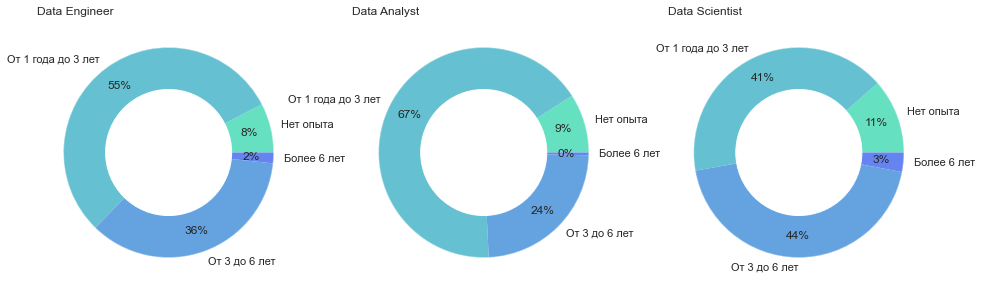

In [277]:
def get_level_stats(data, category):
    level_stats ={
        'Нет опыта': df[(df.Name.str.contains(category)) & (df.Experience == 'Нет опыта')].Ids.count(),
        'От 1 года до 3 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'От 1 года до 3 лет')].Ids.count(),
        'От 3 до 6 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'От 3 до 6 лет')].Ids.count(),
        'Более 6 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'Более 6 лет')].Ids.count(),
    }
    return level_stats
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data engineer')
ax1.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax1.add_artist(centre_circle)
ax1.add_artist(centre_circle1)
ax1.set_title('Data Engineer', size=12, loc='left')

centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data analyst')
ax2.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax2.add_artist(centre_circle)
ax2.add_artist(centre_circle1)
ax2.set_title('Data Analyst', size=12, loc='left')


centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data scientist')
ax3.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax3.add_artist(centre_circle)
ax3.add_artist(centre_circle1)
ax3.set_title('Data Scientist', size=12, loc='left')
plt.show()

### Зарплаты в Data Science

In [278]:
salary = da_de_ds[(da_de_ds.From.notnull()) | (da_de_ds.To.notnull())]

In [279]:
salary = salary[salary['Experience'] != 'Более 6 лет'].sort_values(by='Experience')

In [280]:
salary['mean_salary'] = salary[['From', 'To']].apply(lambda x: x[0] if np.isnan(x[1])\
                                              else (x[1] if np.isnan(x[0]) else (x[0] + x[1])/2), axis=1)

In [299]:
dis = salary[['Name', 'Experience']].append(salary[['Name', 'Experience']])
dis['Salary'] = salary[['From', 'To']].melt()['value'].tolist()

In [300]:
fig = px.box(dis, x="Experience", y="Salary", color='Name', labels={
             "Salary": "Уровень зарплат в тыс. рублях",
             "Experience": "Уровень",
             "Name": "Специальность"
         }, title = 'Распределение зарплат по грейдам')
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
fig.show()

### Анализ навыков

In [301]:
skills = {
    'TensorFlow': {'tensorflow', '\Wtf\W', 'тензорфлоу'},
    'PyTorch': {'pytorch', 'пайторч'},
    'Keras': {'keras', 'керас'},
    'Python': {'python', 'питон', 'пайтон'},
    'Pandas/numpy': {'\Wpandas\W', '\Wnumpy\W'},
    'R': {'\Wr\W'},
    'SQL': {'sql'},
    'Scala': {'scala', 'скала'},
    'Java': {'java', 'джава'},
    'Julia': {'julia', 'джули[ая]'},
    'Go': {'\Wgo\W'},
    'C++': {'c\+\+'},
    'C#': {'c#', 'шарп'},
    'Linux': {'bash', 'баш', 'linux', 'линукс'},
    'JS': {'\Wjs\W', 'java\W?script'},
    'Matlab': {'matlab', 'матлаб'},
    'Django': {'django', 'джанго'},
    'Flutter': {'flutter', 'флатт?ер'},
    'Flask': {'flask', 'фласк'},
    'Spring': {'spring'},
    'Git': {'git', 'github', 'bitbucket', 'gitlab', 'гит', 'гитхаб', 'битбакет', 'гитлаб'},
    'Docker': {'docker', 'докер'},
    'Kubernetes': {'kubernetes', 'кубернетес'},
    'Openshift': {'openshift'},
    'Grafana': {'grafana', 'графан'},
    'Power BI': {'power bi', 'powerbi'},
    'Tableau': {'tableau', 'табло'},
    'Airflow': {'airflow', 'а[э]ирфлоу'},
    'Prometheus': {'prometheus', 'прометеус'},
    'Redshift': {'redshift'},
    'HDFS': {'hdfs'},
    'MapReduce': {'mapreduce'},
    'Spark': {'spark', 'спарк'},
    'Hive': {'hive'},
    'Azure': {'azure'},
    'Hadoop': {'hadoop', 'хадуп'},
    'Kafka': {'kafka', 'кафк[ау]'},
    'RabbitMQ': {'rabbit', 'кролик'},
    'MongoDB': {'mongo.?db'},
    'Firebase': {'firebase'},
    'Cassandra': {'cassandra'},
    'Redis': {'redis'},
    'Redshift': {'redshift'},
    'BigQuery': {'bigquery'},
    'Excel': {'\Wexcel\W', '\Wэксел\W'},
    'Clickhouse': {'clickhouse', 'кликхау[сз]'},
    'XGBoost': {'xgboost', '\Wxgb\W'},
    'LightGBM': {'lightgbm', '\Wlgb\W'},
    'CatBoost': {'catboost'},
    'Scikit-learn': {'scikit', 'sklearn'},
    'SciPy': {'scipy'},
    'MLflow': {'mlflow', 'ml flow'},
}

In [302]:
def get_keyword_df(df, keywords):
    for keyword, keywords_to_search in keywords.items():
        keywords_regex = '|'.join(keywords_to_search)
        df[keyword] = df['Keys'].str.contains(keywords_regex, regex=True)
    keywords_df = pd.DataFrame(columns=['keyword', 'number'])
    for keyword in list(keywords.keys()):
        keywords_df = keywords_df.append({'keyword': keyword, 'number': len(df[df[keyword]])}, ignore_index=True)
    keywords_df = keywords_df.sort_values(by=['number'], ascending=False).reset_index(drop=True)
    keywords_df['perc'] = keywords_df['number'] / len(df) * 100
    return keywords_df

In [310]:
da_de_ds['Keys'] = df.Keys.str.lower()
keyword_df = get_keyword_df(da_de_ds, skills).head(25)
skills_list = [i for i in keyword_df['keyword'].values]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(61.125, 0.5, '')

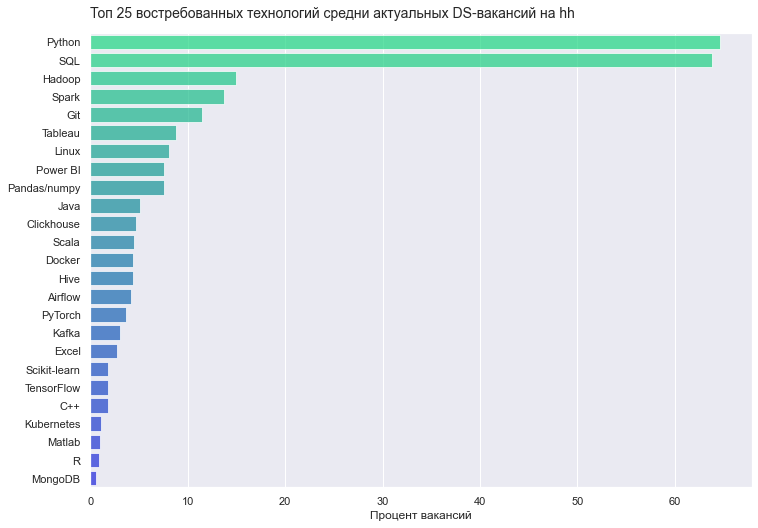

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
fig.tight_layout(w_pad=5)

sns.barplot(ax = ax, data=keyword_df, x='perc', y='keyword', palette=sns.color_palette('winter_r', 25), alpha=0.7)
ax.set_title(label=f'Топ 25 востребованных технологий средни актуальных DS-вакансий на hh', loc='left', size=14, pad=15)
ax.set_xlabel('Процент вакансий')
ax.set_ylabel('')

In [360]:
salary

,Ids,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description,mean_salary
1499,50403064,Сбербанк,data engineer,True,100000.0,150000.0,Нет опыта,Полный день,"['Linux', 'Python', 'Git', 'Bash', 'Docker']",SberDevices занимается созданием экосистемы (с...,125000.0
385,50812636,Фином Технологии,data engineer,True,174000.0,217500.0,Нет опыта,Удаленная работа,"['Python', 'PostgreSQL', 'SQL', 'Английский яз...",Задачи Построение и поддержание инфраструкт...,195750.0
602,47765653,Агентство КИТ Консалт,data scientist,True,156600.0,261000.0,Нет опыта,Полный день,[],Международная производственная компания ищет в...,208800.0
1405,50654414,Кадровое агентство Юнити,data engineer,True,NaN,191400.0,Нет опыта,Полный день,"['MS SQL', 'PostgreSQL']",Нашим клиентом является крупный производитель ...,191400.0
40,50882565,Brand Mobile,data analyst,True,40000.0,70000.0,Нет опыта,Гибкий график,"['Анализ данных', 'Digital Marketing', 'Матема...",В агентство Brand Mobile требуется стажер для ...,55000.0
...,...,...,...,...,...,...,...,...,...,...,...
1239,48837237,Playkot,data engineer,True,200000.0,370000.0,От 3 до 6 лет,Удаленная работа,"['SQL', 'SCALA', 'Spark', 'Java', 'AWS']","Что такое Плэйкот сегодня? 11 лет опыта, 6 люб...",285000.0
68,51042194,FoodRocket,data analyst,True,250000.0,NaN,От 3 до 6 лет,Удаленная работа,"['Tableau', 'SQL', 'Amplitude', 'A/B тесты', '...",Американский FoodTech стартап в поиске Product...,250000.0
67,50932609,24Н Софт,data scientist,True,200000.0,350000.0,От 3 до 6 лет,Полный день,"['SQL', 'Статистический анализ', 'Математическ...","Обязанности: Анализ данных (DWH, BigQuery) по...",275000.0
280,51109345,Joom,data analyst,True,217500.0,NaN,От 3 до 6 лет,Полный день,"['SQL', 'Python', 'Анализ данных', 'Data Analy...","Joom — международный мобильный маркетплейс, са...",217500.0


In [356]:
high = salary['Keys'].str.lower().str.replace("'", "").str.replace(']', '').str.replace('[', '').str.split(',').str.join(',')\
    .str.get_dummies(sep=',').astype(bool)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [363]:
score = pd.merge(high, salary['mean_salary'], left_index=True, right_index=True)

In [369]:
score[score[score.columns[5]] == True]

,a/b тесты,ad hoc анализ,agile,agile project management,airflow,alpha launch,amplitude,analysis,analytical skills,appsflyer,...,tableau,uml,анализ данных,аналитика,английский язык,базы данных,работа в команде,управление проектами,управленческая отчетность,mean_salary
580,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,350000.0


In [370]:
for i in score.columns:
    print(i)

 a/b тесты
 ad hoc анализ
 agile
 agile project management
 airflow
 alpha launch
 amplitude
 analysis
 analytical skills
 appsflyer
 aws
 azure devops
 b2c маркетинг
 bash
 beta-тестирования
 bi
 big data
 bigquery
 bpmn
 business analysis
 business english
 business intelligence
 business intelligence systems
 c++
 clickhouse
 coaching
 code development
 computer vision
 core
 customer orientation
 cистемы управления базами данных
 data analysis
 data mining
 data science
 data scientist
 deep learning
 digital marketing
 docker
 dwh
 elastic
 engineering
 english
 english c1
 etl
 financial analysis
 front and dashboard
 git
 gitlab
 google adwords
 google analytics
 google bigquery
 google cloud platform
 google core
 google data studio
 google docs
 google sheets
 google tag manager
 hadoop
 highload
 hive
 it analysis
 java
 javascript
 jira
 js
 jupyter notebooks
 kafka
 kanban
 kubernetes
 leadership skills
 linux
 machine learning
 macros
 market research
 marketing
 marketing